In [ ]:
# !gdown --id 1fZWlKmWHgQ_errkbvr2eHAr5C00ZkxgE
!pip install --q usaddress --user
!pip install --q plotly --user
!pip install -qU seaborn --user

Downloading...
From: https://drive.google.com/uc?id=1fZWlKmWHgQ_errkbvr2eHAr5C00ZkxgE
To: /content/rest_data_us.csv
100% 609k/609k [00:00<00:00, 53.3MB/s]

Usage:   
  pip3 <command> [options]

Commands:
  install                     Install packages.
  download                    Download packages.
  uninstall                   Uninstall packages.
  freeze                      Output installed packages in requirements format.
  list                        List installed packages.
  show                        Show information about installed packages.
  check                       Verify installed packages have compatible dependencies.
  config                      Manage local and global configuration.
  search                      Search PyPI for packages.
  cache                       Inspect and manage pip's wheel cache.
  wheel                       Build wheels from your requirements.
  hash                        Compute hashes of package archives.
  completion                 

# Los Angeles Restaurant Sector Analysis & Recommendations
For this project we are interested in analyzing the current Los Angeles restaurant market conditions with the aim of opening a small restaurant in the greater Los Angeles area. We will investgate an open source data set obtained from Yandex Practicum 100 by way of [the city of Los Angeles open data platform](https://data.lacity.org/) released under the Public Domain U.S. Government license

## Steps
1. We will first load and inspect the condition of the data, its columns, values, and categories noting the level of prepocessing required as this will help determine the confidence of our analysis and presentation
2. Preprocess any errors listed from the intitial investigation
3. Post processing we will graph and extract insights answering the following key questions
  - What are the dominant food & beverage businesses in Los Angeles?
  - What Proportion Of These Businesses Are Chains?
  - What is the average seat count for each type of business?
  - What is the seat count distribution for each type of business?
  - How many stores do the chain business have?
  - What defines a chain restaurant?
  - What are the top ten streets by number of restaurants?
  - What are the business type proportions of the top ten streets?
  - What is the seat count distribution among he top ten streets?
  - What is the seat count distribution By Business Type among top ten streets 
  - What are the top ten streets by number of restaurants?
  - What are the proportions of business types on quiet streets?
  - What is the seat count distribution among quiet streets?

4. Finally we will compiles and port the analysis and graphs to a presentation with the aim of presenting it to potential investors in our restaurant 

## Conclusions
I will talk through and draw conclusions throughout the notebook but the overall conclusions will be found on the presentation after compiling and reviewing the data 

- Presentation: [link](https://drive.google.com/drive/folders/1b-2wce1MdWN_eaJAugVAbIO2I08EyrCb)

# Importing Libraries & Dataset
- I will talk through and draw conclusions throughoput the notebook but most of the overall conclusions will be found on the presentation after compiling and reviewing the data
- As I am familiar with seaborn I am going to focus on plotly in this notebook however I will use seaborn for some graphs on the presentation are it is easer to add elements such as data labels
- The seaborn code will be commeted out but left in place if reference is needed from the presentaion 


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 12, 6


import plotly.express as px

import re
import usaddress

In [ ]:
df = pd.read_csv("/datasets/rest_data_us.csv")

## Data description

rest_data table:
- object_name — establishment name
- chain — chain establishment (TRUE/FALSE)
- object_type — establishment type
- address — address
- number — number of seats

In [ ]:
df.head(5)

,id,object_name,address,chain,object_type,number
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9651 non-null   int64 
 1   object_name  9651 non-null   object
 2   address      9651 non-null   object
 3   chain        9648 non-null   object
 4   object_type  9651 non-null   object
 5   number       9651 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 452.5+ KB


# Renaming Columns 
- Column names are too ambiguous lets update these
- Lets also take a quick look at the type column categories to see what categories of businesses we have in the dataset
- Note we are missing some values in chain column but lets check for duplicates first

In [ ]:
df.columns = ['businessId', 'businessName', 'businessAddress', 'isChain', 'businessType', 'seatCount']

In [ ]:
list(df['businessType'].unique())

['Cafe', 'Restaurant', 'Fast Food', 'Bakery', 'Bar', 'Pizza']

# Investigating Duplicates & Chain Attribution

In [ ]:
df[df.duplicated()]

,businessId,businessName,businessAddress,isChain,businessType,seatCount


In [ ]:
df[df['businessId'].duplicated()]

,businessId,businessName,businessAddress,isChain,businessType,seatCount


- No duplicate rows or ID's which is good but lets look for duplicate names which are not chains

In [ ]:
chainInvestigation = df[df.duplicated(subset=['businessName'], keep=False)]
# chainInvestigation.head()

print(len(chainInvestigation))
chainInvestigation[chainInvestigation['isChain'] == False].head()

1503


,businessId,businessName,businessAddress,isChain,businessType,seatCount
104,11890,BARNEY'S BEANERY,200 WORLD WAY # 240,False,Bar,75
107,11893,ADMIRALS CLUB,400 WORLD WAY,False,Restaurant,118
128,11914,ADMIRALS CLUB,500 WORLD WAY,False,Restaurant,205
250,12036,GELSON'S MARKET,5877 FRANKLIN AVE,False,Restaurant,13
441,12227,PRESS BROTHERS JUICERY,317 S BROADWAY 3 F-2,False,Restaurant,1


In [ ]:
df['businessName'].drop_duplicates(keep='last', inplace=True)

- Setting keep = False and here we can see all instances of the duplicated rows using google on some of the duplicate entries we see that they are referencing an old and new location for the same business so while there is two or more instances they are not a chain 
- However as they appear to be chronologically entered into the dataset we droped the first (oldest) instance
- There seems to be some misclassification with Press Brothers Juicery being classed as a restaurant we can look into this a little further
- We also noticed some 1 seat restaurants which when googles is not correct their websites and google images show seats lets count and drop these instances for all business types

# Investigating Business Type With 1 Seat Count 

In [ ]:
typeCount = df[df['seatCount'] == 1]['businessType'].value_counts()

fig = px.bar(typeCount, 
       x=typeCount.keys(), 
       y=typeCount.values, 
       color=typeCount.keys(), 
       title='Proportion of Business Types With 1 Seat Entries - Total: {}'.format(len(df[df['seatCount'] == 1])))


fig.show()

In [ ]:
df = df[df['seatCount'] > 1].copy()

# Chain Attribution Cont'd
- We also noticed some chains which have a numerical attribution
- We will need to remove this in order to group and investigate chains 

In [ ]:
# df[df['businessName'].str.contains("SUBWAY")]
# df[df['businessName'].str.contains("JAMBA")]
df['cleanName'] = df['businessName'].apply(lambda x: re.sub("#\d{1,10}|-\d{1,10}","", x))

In [ ]:
df[df['businessName'].str.contains("JAMBA")].tail()

,businessId,businessName,businessAddress,isChain,businessType,seatCount,cleanName
7812,19598,JAMBA JUICE #399,11074 SANTA MONICA BLVD,True,Restaurant,19,JAMBA JUICE
7866,19652,JAMBA JUICE #767,308 WESTWOOD PLZ A260,True,Restaurant,33,JAMBA JUICE
7994,19780,JAMBA JUICE #527,2919 LOS FELIZ BLVD STE #2,True,Restaurant,5,JAMBA JUICE
8177,19963,JAMBA JUICE,331 SANTA MONICA BLVD,True,Restaurant,5,JAMBA JUICE
9024,20810,JAMBA JUICE #1514,4729 VENICE BLVD,True,Restaurant,43,JAMBA JUICE


- Seems to have done the trick however there is a major issue with the classiciation of Jamba Juice as a 'Restaurant' 
- We can see that is classed in the Beverages section of Fast food and fast casual restaurant chains in the United States on [wiki](https://en.wikipedia.org/wiki/Jamba_Juice)
- With our list I beleieve cafe is a more appropriate classification for such a business
- Let's first see what other businesses may be misclassified as restaurants before overwriting the category label

## Juice Bar Attribution

In [ ]:
misclassfiedBusinessCafe = df[(df['businessName'].str.contains('CAFE|JUICE BAR')) & (df['businessType'] == 'Restaurant')]

print('Number Of Cafe/Juice Classified As Restaurants:', len(misclassfiedBusinessCafe),'\n')

misclassfiedBusinessCafe.head()

Number Of Cafe/Juice Classified As Restaurants: 530 



,businessId,businessName,businessAddress,isChain,businessType,seatCount,cleanName
20,11806,CRYSTAL CAFE,3500 W 6TH ST STE #321,False,Restaurant,16,CRYSTAL CAFE
21,11807,ORANGE TREE CAFE,3500 W 6TH ST STE #220,False,Restaurant,14,ORANGE TREE CAFE
24,11810,M CAFE DE CHAYA,7119 MELROSE AVE,True,Restaurant,43,M CAFE DE CHAYA
26,11812,LA INDIA BONITA CAFE,1277 S INDIANA ST,False,Restaurant,19,LA INDIA BONITA CAFE
30,11816,CAFE 153,1125 3/4 WALL ST,False,Restaurant,5,CAFE 153


In [ ]:
df[(df['businessName'].str.contains('JUICE BAR')) & (df['businessType'] != 'Restaurant')]['businessType'].value_counts()

Bar    20
Name: businessType, dtype: int64

In [ ]:
df.loc[(df['businessName'].str.contains('JUICE BAR')) & (df['businessType'] == 'Restaurant'), 'businessType'] = 'Bar'

- Here we can see juice bars should be classified as Bar 
- We changed the attributions from Restaurant to Bar
- Lets see what are the most common attributions for "CAFE"

### Cafe Attribution

In [ ]:
print(df[(df['businessName'].str.contains('CAFE')) & (df['businessType'] != 'Restaurant')]['businessType'].value_counts())
df[(df['businessName'].str.contains('CAFE')) & (df['businessType'] != 'Restaurant')].head()

Bakery       34
Bar          10
Cafe          3
Fast Food     2
Pizza         2
Name: businessType, dtype: int64


,businessId,businessName,businessAddress,isChain,businessType,seatCount,cleanName
728,12514,BARHAM CAFE,3800 BARHAM BLVD # 106,True,Bar,12,BARHAM CAFE
736,12522,"SPECIALTY'S CAFE & BAKERY, INC",400 S HOPE ST STE 110,True,Bakery,90,"SPECIALTY'S CAFE & BAKERY, INC"
921,12707,BIBI'SBAKERY AND CAFE,8928 W PICO BLVD,True,Bakery,8,BIBI'SBAKERY AND CAFE
1198,12984,CRAFT COFFEE AND GOOD FOOD CAFE,5636 HOLLYWOOD BLVD,True,Cafe,25,CRAFT COFFEE AND GOOD FOOD CAFE
1246,13032,AU BON PAIN BAKERY CAFE,10833 LE CONTE AVE,True,Bakery,26,AU BON PAIN BAKERY CAFE


In [ ]:
df.loc[(df['businessName'].str.contains('CAFE')) & (df['businessType'] == 'Restaurant'), 'businessType'] = 'Cafe'

- Interesting, we can see that, exluding Restaurant, bakery is actually the most common attribution for businesses with Cafe in the name and looming at the data we can see the combination of Bakery and Cafe in the businessName
- Still for businesses with 'CAFE' in the title we changed Restaurant attributions with Cafe 
- We left leave Bar, Fast Food, and Pizza 

# Bakery Attribution

In [ ]:
print(df[(df['businessName'].str.contains('BAKERY')) & (df['businessType'] != 'Bakery')]['businessType'].value_counts())
df[(df['businessName'].str.contains('BAKERY')) & (df['businessType'] != 'Restaurant')].head()

Cafe         4
Bar          2
Pizza        2
Fast Food    1
Name: businessType, dtype: int64


,businessId,businessName,businessAddress,isChain,businessType,seatCount,cleanName
11,11797,POONG NYUN BAKERY,928 S WESTERN AVE STE 109,True,Bakery,17,POONG NYUN BAKERY
14,11800,CUSCATLECA BAKERY,2501 W SUNSET BLVD #A,True,Bakery,26,CUSCATLECA BAKERY
34,11820,MUSH BAKERY,5224 W SUNSET BLVD,True,Bakery,15,MUSH BAKERY
44,11830,LA MONARCA BAKERY,5835 N FIGUEROA ST,True,Bakery,35,LA MONARCA BAKERY
96,11882,CELAYA BAKERY,1630 W SUNSET BLVD,True,Bakery,16,CELAYA BAKERY


In [ ]:
df.loc[(df['businessName'].str.contains('BAKERY')) & (df['businessType'] == 'Restaurant|Bar|Pizza|Fast Food'), 'businessType'] = 'Bakery'

- In this instance we changed Bar, Pizza, and Fast Food to Bakery

# Bar Attribution
- We saw alot of BAr & Grill businesses so lets exlude bars and restaurants and see what else businesses with "BAR" in the title are being classed as

In [ ]:
print(df[(df['businessName'].str.contains('BAR')) & (~df['businessType'].str.contains('Bar|Restaurant'))]['businessType'].value_counts())
df[(df['businessName'].str.contains('BAR')) & (~df['businessType'].str.contains('Bar|Restaurant'))].head()
# df[(df['businessName'].str.contains('BAR')) & (~df['businessType'].str.contains('Bar|Restaurant'))].tail()

Cafe         13
Fast Food     7
Pizza         1
Name: businessType, dtype: int64


,businessId,businessName,businessAddress,isChain,businessType,seatCount,cleanName
137,11923,ASHLAND BAR EARTH BAR / PANDA EXPRESS ASHLAND ...,300 WORLD WAY # 329,True,Fast Food,25,ASHLAND BAR EARTH BAR / PANDA EXPRESS ASHLAND ...
574,12360,D-TOWN BURGER BAR,216 W 6TH ST,False,Fast Food,2,D-TOWN BURGER BAR
1307,13093,BRASIL KISS COFFEE BAR,6350 SANTA MONICA BLVD,True,Cafe,2,BRASIL KISS COFFEE BAR
1890,13676,LA BURGER BAR,8581 W PICO BLVD,False,Fast Food,37,LA BURGER BAR
2515,14301,TIAGO COFFEE BAR & KITCHEN,7080 HOLLYWOOD BLVD STE 106,False,Cafe,36,TIAGO COFFEE BAR & KITCHEN


- I'm fine with these attributions so we wont need to overwrite anytthing here

# Attribution Conclusions

- This issue was a lot more pervaisive than I first thought
- The steps taken here have helped to correct the mis-attributions
- However our confidence in this dataset has been affected 

## Dealing With NaN isChain Values
- Lets finally investigate the NaN isChain values we spotted at during the import

In [ ]:
df[df['isChain'].isna()]

,businessId,businessName,businessAddress,isChain,businessType,seatCount,cleanName
7408,19194,TAQUERIA LOS 3 CARNALES,5000 E WHITTIER BLVD,NaN,Restaurant,14,TAQUERIA LOS 3 CARNALES
8648,20434,THE LEXINGTON THEATER,129 E 3RD ST,NaN,Restaurant,35,THE LEXINGTON THEATER


In [ ]:
df[df['cleanName'].str.contains("TAQUERIA LOS 3 CARNALES")]
# df[df['cleanName'].str.contains("THE LEXINGTON THEATER")]

df.loc[df['isChain'].isna(), 'isChain'] = False

- A simple assignments of False will suffice here

## Formatting String Columns
- For the sake of the graphs later lets use the title() method to the string columns

In [ ]:
cols = ['businessName',	'businessAddress', 'cleanName']

for col in cols:
  df[col] = df[col].str.title()

In [ ]:
df['cleanName'].unique()

array(['Habitat Coffee Shop', "Reilly'S", 'Street Churros', ...,
       'Fin-Melrose', 'Medidate Coffee', 'Cafe Sprouts'], dtype=object)

- Despite Reily'S it seems to work okay we might just lowercase later

## Parsing Out Street Name From Address

- We will plot the top and bottom streets by business / seat count among others so we will clean and parse of the business addresses
- We are not interested in StreetNamePostType or StreetNamePreDirectional here as they will return too fine grained of an address making street group counts too low to establish a reliable feature/count distriubtions

In [ ]:
# test_street = df.iloc[0]['businessAddress']
# parser = usaddress.parse(test_street)
# parser

In [ ]:
# dict_address = {}

# for i in parser:
#   dict_address[i[1]] = i[0]

# dict_address

In [ ]:
def parseStreet(address):
    if address.startswith('Olvera'):
        clean_adress='Olvera, Los Angeles'
    elif address.startswith('1033 1/2 Los Angeles'):
        clean_adress='1033 1/2 Los Angeles st, Los Angeles'
    else:
        raw_address=usaddress.parse(address)
        dict_address={}
        for i in raw_address:
            dict_address.update({i[1]:i[0]})
        clean_adress=dict_address['AddressNumber']+" "+str(dict_address['StreetName'])+str(', Los Angeles')
    return clean_adress

In [ ]:
df['cleanAddress'] = df['businessAddress'].apply(parseStreet)
df['cleanAddress'] = df['cleanAddress'].str.title()
df['cleanAddress'] = df['cleanAddress'] + ", USA"

In [ ]:
df.head()

,businessId,businessName,businessAddress,isChain,businessType,seatCount,cleanName,cleanAddress
0,11786,Habitat Coffee Shop,3708 N Eagle Rock Blvd,False,Cafe,26,Habitat Coffee Shop,"3708 Rock, Los Angeles, USA"
1,11787,Reilly'S,100 World Way # 120,False,Restaurant,9,Reilly'S,"100 World, Los Angeles, USA"
2,11788,Street Churros,6801 Hollywood Blvd # 253,False,Fast Food,20,Street Churros,"6801 Hollywood, Los Angeles, USA"
3,11789,Triniti Echo Park,1814 W Sunset Blvd,False,Restaurant,22,Triniti Echo Park,"1814 Sunset, Los Angeles, USA"
4,11790,Pollen,2100 Echo Park Ave,False,Restaurant,20,Pollen,"2100 Park, Los Angeles, USA"


- US Address library works well but again for the sake of graphing later we might just parse out the street

# Preprocessing Conclusions
- The data looked quite clean and full on import, we cleaned up the missing isChain values
- However through a combination of python and google we quickly spotted some errouneous values for seat counts with some buisinesses hhaving single seat counts while a google image of the business shows many seats. We could have imputed a mean/median based on business type but as it was only 187 we decided to drop them
- We also saw some misattributed businessTypes, this was trickier to address though we reassigned some categories based on an investigation of businessName vs businessType proportions
- Finally we used title method on the string columns and parsed out a much cleaner address both of which should help our graphs look better during the next stages 


## Investigating Seating Distributions
- We will plot overall distributions, per businessType, and isChain to see what patterns emerge
- In this instance we will use seaborn as plotly's histgrams are an eye sore

In [ ]:
df['seatCount'].describe().astype(int)

count    9464
mean       44
std        47
min         2
25%        14
50%        27
75%        46
max       229
Name: seatCount, dtype: int64

In [ ]:
px.histogram(df, x='seatCount')

In [ ]:
df[(df['seatCount'] >= 50) & (df['seatCount'] <=60)]

,businessId,businessName,businessAddress,isChain,businessType,seatCount,cleanName,cleanAddress


- Seems most businesses have less than 50 seats with a gap between 50 and 60 seats, need to investigate is this an error in the data or some kind of strange regulation
- Lets look at seating distributions between business types but first lets plot a business type count

# Business Type Proportions

In [ ]:
typeCount = df['businessType'].value_counts()
typeCount

Restaurant    6595
Fast Food     1039
Cafe           960
Pizza          316
Bar            281
Bakery         273
Name: businessType, dtype: int64

In [ ]:
fig = px.pie(typeCount, 
             values=typeCount.values, 
             names=typeCount.keys(), 
             title='Proportions Of Establishment Types'
             )



fig.show()

- Even after our reclassifying earlier we still have 7x higher count for restaurants to the next highest types which are Fast Food and cafe with similar counts
- Pizza, Bar, and Bakery also all have similar proportions around 3%
- Lets check out the seating distribution among the business types

# Seating Distributions

In [ ]:
seatDistribution = df.groupby('businessType')['seatCount'].describe().astype(int)
seatDistribution['skew'] = df.groupby('businessType')['seatCount'].skew().round(2)
seatDistribution

,count,mean,std,min,25%,50%,75%,max,skew
businessType,,,,,,,,,
Bakery,273,22,25,2,10,18,25,218,4.44
Bar,281,46,46,2,16,31,48,227,1.66
Cafe,960,35,40,2,12,24,41,228,2.61
Fast Food,1039,32,35,2,11,22,37,227,2.33
Pizza,316,28,35,2,10,19,29,216,3.00
Restaurant,6595,49,50,2,16,31,49,229,1.65


In [ ]:
fig = px.box(df, x='businessType', y="seatCount", color='businessType', title='Seat Count Distribution Per Business Type')
fig.show()

- All distributions are right skewed of which Restaurant and Bars have the lowest skew (closest to normal) while Bakery and Pizza have the highest skew both and the graph indicating they have a cluster of low seat counts but suffer from a higher volume of extreme outliers 
- Pizza parlours and Bakerys appear to have the lowest average and median seat counts
- Lets look at the effect the isChain feature has on the seating distributions for each business type but first lets look at the proportions of chain and nonChain businesses

# Investigate the proportions of chain and nonchain establishments


In [ ]:
chainCount = df['isChain'].value_counts()

fig = px.pie(chainCount, 
             values=chainCount.values, 
             names=chainCount.keys(), 
             title='Proportion of Chain and NonChain Establishments'
             )

fig.add_annotation(x=0.015, y=1.05,
            text="Chains:{}".format(str(chainCount)[19:27]),
            showarrow=False,
            yshift=10)

fig.add_annotation(x=0.015, y=1,
            text="Non Chains:{}".format(str(chainCount)[5:13]),
            showarrow=False,
            yshift=10)

fig.show()

In [ ]:
px.histogram(df, x='businessType', color="isChain", barmode='group', title='Proportion of Chain and NonChain Businesses Per Business Type')

In [ ]:
df[df['businessType'] == 'Bakery'].head()

,businessId,businessName,businessAddress,isChain,businessType,seatCount,cleanName,cleanAddress
11,11797,Poong Nyun Bakery,928 S Western Ave Ste 109,True,Bakery,17,Poong Nyun Bakery,"928 Western, Los Angeles, USA"
14,11800,Cuscatleca Bakery,2501 W Sunset Blvd #A,True,Bakery,26,Cuscatleca Bakery,"2501 Sunset, Los Angeles, USA"
34,11820,Mush Bakery,5224 W Sunset Blvd,True,Bakery,15,Mush Bakery,"5224 Sunset, Los Angeles, USA"
44,11830,La Monarca Bakery,5835 N Figueroa St,True,Bakery,35,La Monarca Bakery,"5835 Figueroa, Los Angeles, USA"
96,11882,Celaya Bakery,1630 W Sunset Blvd,True,Bakery,16,Celaya Bakery,"1630 Sunset, Los Angeles, USA"


- A quick search here is showing some innaccurate attributions of chains with all bakeries listed as chain when a quick google search shows some are independent with only one location

In [ ]:
df = df[df['businessType'] != 'Bakery']

In [ ]:
# graph = sns.countplot(data=df, x='businessType', hue='isChain')
# plt.title('Proportion of Chain and NonChain Businesses Per Business Type')

# for p in graph.patches:
#              graph.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
#                  ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
#                  textcoords='offset points')

# plt.savefig('Chain vs Non Chain')
# plt.show()

In [ ]:
fig = px.box(df, x='businessType', y="seatCount", color='isChain', title='Seating Distribution Per Business Type and isChain Status')
fig.show()

In [ ]:
# plt.figure(figsize=(16,6))
# sns.boxplot(data=df, x='businessType', y='seatCount', hue='isChain')
# plt.savefig('seatCounts.png')
# plt.show()

In [ ]:
avgSeats = df.groupby(['businessType', 'isChain'])[['seatCount', 'businessId']].agg({'seatCount':'mean', 'businessId':'count'}).reset_index().round()
avgSeats

,businessType,isChain,seatCount,businessId
0,Bar,False,48.0,209
1,Bar,True,43.0,72
2,Cafe,False,40.0,589
3,Cafe,True,29.0,371
4,Fast Food,False,24.0,451
5,Fast Food,True,39.0,588
6,Pizza,False,32.0,165
7,Pizza,True,26.0,151
8,Restaurant,False,51.0,4451
9,Restaurant,True,46.0,2144


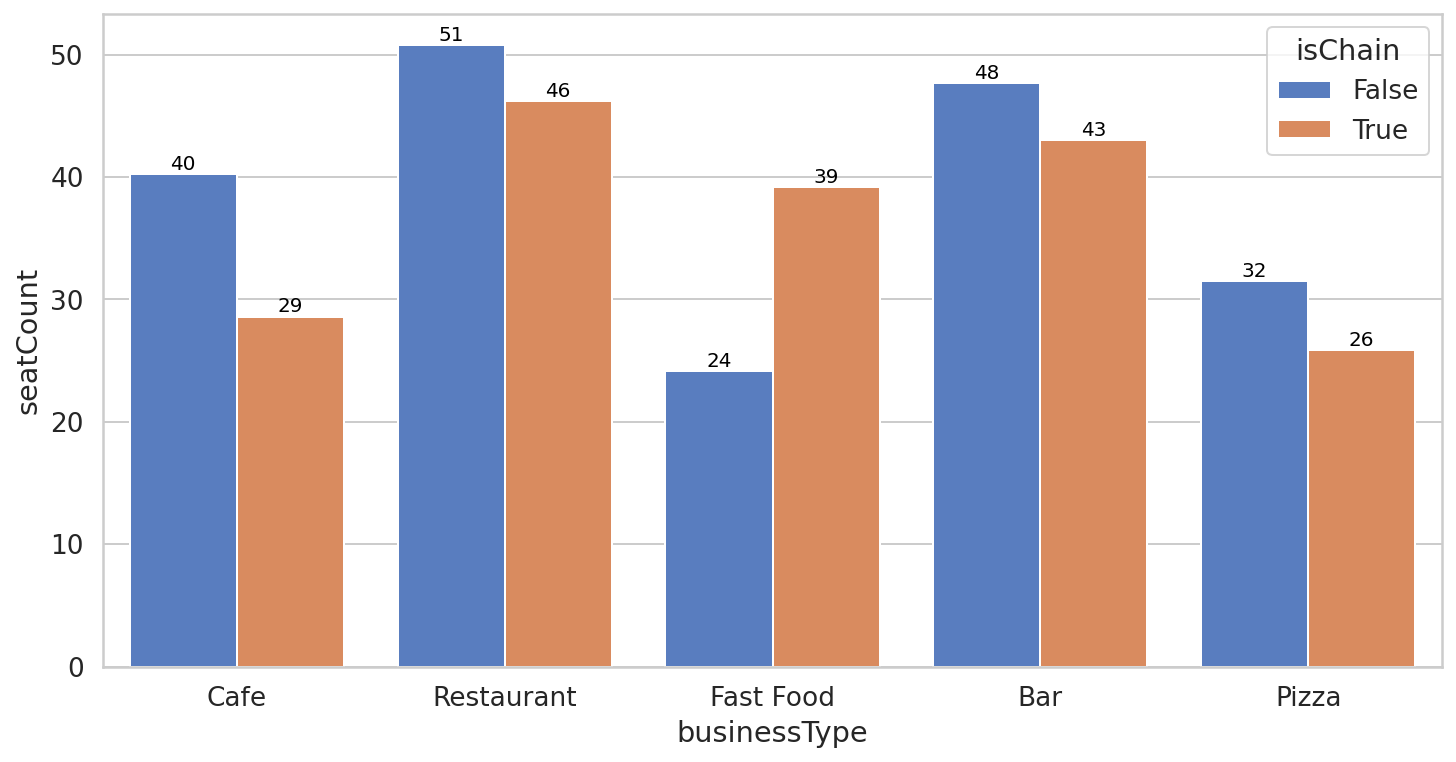

In [ ]:
graph2 = sns.barplot(data=df, x='businessType', y='seatCount', hue='isChain', estimator=np.mean, ci=None, capsize=.2)
for p in graph2.patches:
             graph2.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')
plt.savefig('avgSeats.png')           

- We can see some clear patterns regarding seating among business types and chain/independent businesses
- Fast Food is the only type which has more seats among chain businesses there is also a higher concentration of outliers among them but the distribution skews right and higher with the median of chain businesses equalling the 75th percentile of independent businesses 
- Chain vs independent Bars also quite close however there is around 2.5x the number of independent Bars to chains 
- For Restaurants we can see a some differences between the means but a significant between the distributions with chain restaurants have fewer seats at all levels apart from outliers of which both types have a similar proportion

# What characterizes chains: 
Many establishments with a small number of seats or few establishments with a lot of seats?

- We have established some answers here based on the seatCounts among business types and chain status however we need to see the distribution of chain store counts and see if we have a few chain businesses with many stores or many chain businesses with few stores

In [ ]:
chains = df[df['isChain'] == True]
nonChain = df[df['isChain'] == False]

In [ ]:
chainCounts = chains.groupby(['cleanName', 'businessType'])[['businessId', 'seatCount']].agg(
                                        {'businessId':'count',
                                         'seatCount':'mean'}).reset_index()

chainCounts.columns = ['chainName', 'chainType', 'count', 'avgSeats']
chainCounts['avgSeats'] = chainCounts['avgSeats'].astype(int)

chainCounts = chainCounts.sort_values(by='count', ascending=False)
chainCounts.head(20)

,chainName,chainType,count,avgSeats
1607,Starbucks Coffee,Cafe,84,24
1620,Subway,Fast Food,76,16
1737,The Coffee Bean & Tea Leaf,Cafe,47,26
721,Jack In The Box,Restaurant,33,61
1085,Mcdonald'S,Fast Food,33,107
1619,Subway,Fast Food,31,17
1351,Pizza Hut,Pizza,29,14
1935,Yoshinoya,Restaurant,22,49
478,El Pollo Loco,Restaurant,22,66
1673,Taco Bell,Fast Food,22,43


- Okay we have our store and average seat counts
- Next we will establish the 95th percentile of chain store counts and use this to split the dataset between chains with many stores and chains with few stores so we can plot the avg seat count distributions 

In [ ]:
chainCounts.describe().astype(int)

,count,avgSeats
count,1965,1965
mean,1,43
std,3,45
min,1,2
25%,1,16
50%,1,27
75%,2,46
max,84,229


In [ ]:
storeCounts = chainCounts['count'].value_counts(normalize=True).round(3)

fig = px.pie(storeCounts, 
             values=storeCounts.values, 
             names=storeCounts.keys(), 
             title='Proportion of Chain Stores'
             )
fig.show()

In [ ]:
chainCounts[chainCounts['count'] ==1].head()

,chainName,chainType,count,avgSeats
1159,Mom'S Donuts & Chinese Food,Fast Food,1,16
1160,Mom'S Restaurant,Restaurant,1,9
1171,Mr Marcel Restaurant & Deli,Restaurant,1,109
1424,Real Food Daily,Restaurant,1,142
1425,"Real Food Daily, Llc",Restaurant,1,74


In [ ]:
df[df['businessName'].str.contains('Subway')]

,businessId,businessName,businessAddress,isChain,businessType,seatCount,cleanName,cleanAddress
40,11826,Subway -52105,255 S Grand Ave Ste 101,True,Fast Food,37,Subway,"255 Grand, Los Angeles, USA"
82,11868,Subway #39685,704 W 1St St,True,Fast Food,3,Subway,"704 1St, Los Angeles, USA"
118,11904,Subway #14183,508 W 7Th St,True,Fast Food,4,Subway,"508 7Th, Los Angeles, USA"
162,11948,Subway #12484,5339 W Centinela Ave Ste #A,True,Fast Food,24,Subway,"5339 Centinela, Los Angeles, USA"
182,11968,Subway #1763,3959 Wilshire Blvd Ste B-7,True,Fast Food,17,Subway,"3959 Wilshire, Los Angeles, USA"
...,...,...,...,...,...,...,...,...
8739,20525,Subway,11762 San Vicente Blvd,True,Fast Food,23,Subway,"11762 Vicente, Los Angeles, USA"
8744,20530,Subway #24017,1821 E Cesar E Chavez St,True,Fast Food,18,Subway,"1821 Cesar, Los Angeles, USA"
8774,20560,Subway #39254,4770 E Cesar Chavez Ave,True,Fast Food,21,Subway,"4770 Chavez, Los Angeles, USA"
8794,20580,Subway #25803,5536 E Whittier Blvd,True,Fast Food,20,Subway,"5536 Whittier, Los Angeles, USA"


In [ ]:
print('95th Percentile Chain Store Count:', chainCounts['count'].quantile(0.95).astype(int))

95th Percentile Chain Store Count: 3


In [ ]:
manyStores = chainCounts[chainCounts['count'] >2]
fewStores = chainCounts[chainCounts['count'] <=2]

print('Number Of Chains With More Than 2 Stores:', len(manyStores))
print('Number Of Chains With 2 or More Stores:', len(fewStores))

Number Of Chains With More Than 2 Stores: 160
Number Of Chains With 2 or More Stores: 1805


In [ ]:
print('Average Of Average Seat Counts For Big Chains:', round(manyStores['avgSeats'].mean()))
print('Median Of Average Seat Counts For Big Chains:', round(manyStores['avgSeats'].median()))
print()
print('Average Of Average Seat Counts For Small Chains:',round(fewStores['avgSeats'].mean()))
print('Median Of Average Seat Counts For Small Chains:',round(fewStores['avgSeats'].median()))

Average Of Average Seat Counts For Big Chains: 38
Median Of Average Seat Counts For Big Chains: 24

Average Of Average Seat Counts For Small Chains: 45
Median Of Average Seat Counts For Small Chains: 27


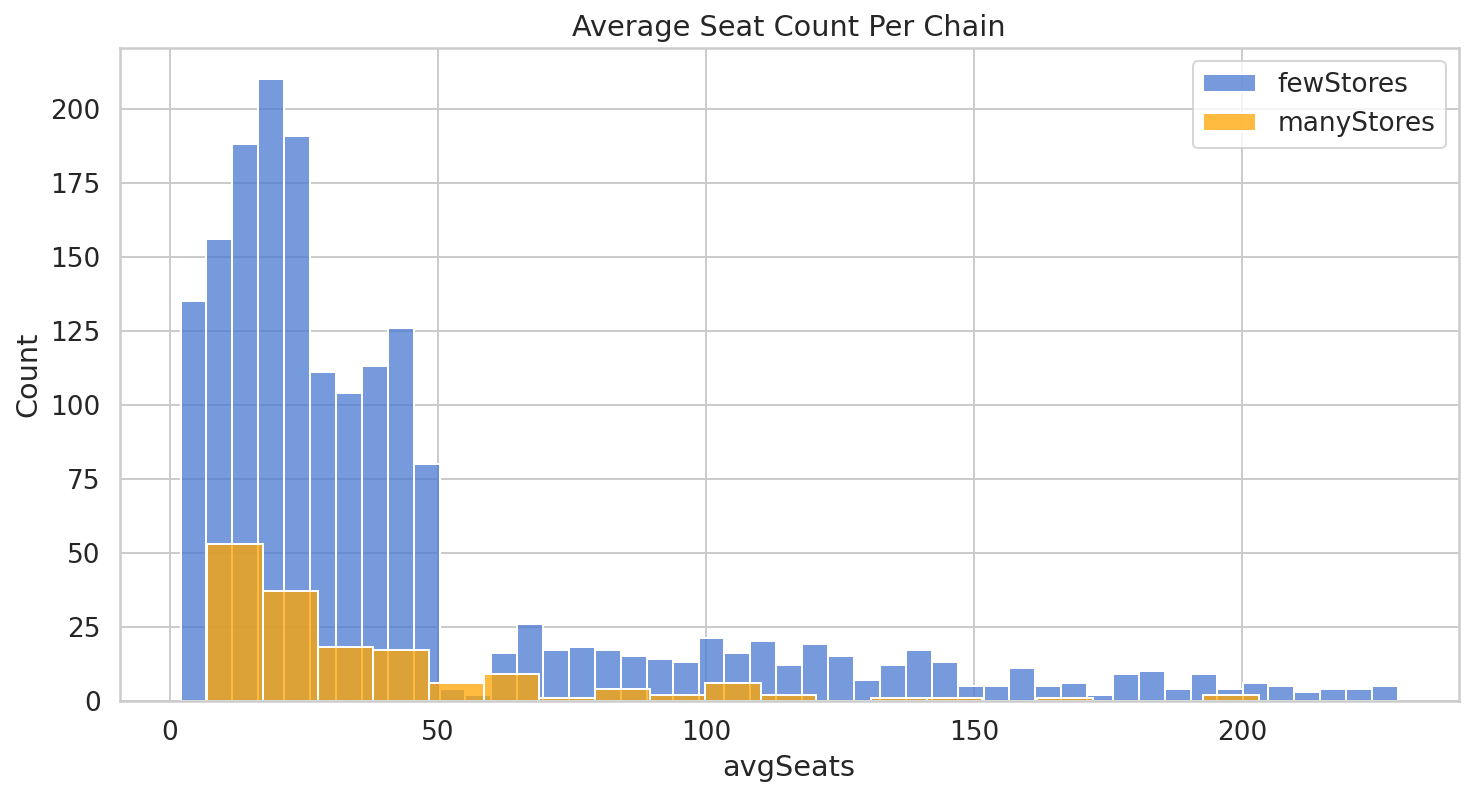

In [ ]:
plt.title('Average Seat Count Per Chain')
sns.histplot(fewStores['avgSeats'])
sns.histplot(manyStores['avgSeats'], color='orange')
plt.legend(['fewStores', 'manyStores'])
plt.show()

In [ ]:
df[df['isChain'] == False]['seatCount'].agg(['mean','median'])

mean      47.003581
median    28.000000
Name: seatCount, dtype: float64

# Conclusion
- Over 82% of the dataset have only 1 chain store in the Los angeles area 95% have 2 stores the remaining 5% of businesses have between 3 and 47 stores. 
- In terms of seat count chain stores in general have fewer seats than independent businesses (excluding Fast Food) and we can see that both chains with few and many store have fewer than 50 seats
- In general we can say that, among chain business, most chains have fewer than 3 three chained stores and fewer seats on average than independent businesses
- A final note is that chain businesses with many stores (The Coffee Bean & Tea Leaf, Subwaym Domino's Pizza etc..) have even fewer seats futher evidence that chains have fewer seats

# Determine the average number of seats for each type of restaurant
- On average, which type of restaurant has the greatest number of seats? 


In [ ]:
avgSeatPerRest = df.groupby('businessType')['seatCount'].mean()\
                .astype(int).reset_index()\
                .sort_values(by='seatCount', 
                ascending=False
                )
                
px.bar(avgSeatPerRest, x='businessType', y="seatCount", color='businessType', title='Average Seat Count Per Business Type')

- Bars and Restaurants haave the highest number of seats on average not suprising for Restaurants who also have the highest count of entries in the data but Bars make up just a small percentage
- We saw ealier that chain Bars have a wider distribution but independent Bars have many more outliers in both cases the 75th percentile lands around 50 

# Graph of the top ten streets by number of establishments

In [ ]:
# df[df['cleanAddress'].str.contains('928 Western')]
# df[df['cleanAddress'].str.contains('0928 Western')]

df.loc[df['cleanAddress'] == '0928 Western, Los Angeles, USA', 'cleanAddress'] = '928 Western, Los Angeles, USA'

In [ ]:
establishmentCount = df.pivot_table(
    index='cleanAddress', 
    columns='businessType', 
    values='businessId',
    aggfunc='count'
  ).fillna(0).astype(int)

establishmentCount['totalEst'] = establishmentCount.sum(axis=1)
establishmentCount = establishmentCount.sort_values(by='totalEst', ascending=False)

establishmentCount.head()

businessType,Bar,Cafe,Fast Food,Pizza,Restaurant,totalEst
cleanAddress,,,,,,
"10250 Monica, Los Angeles, USA",2,1,3,2,53,61
"6333 3Rd, Los Angeles, USA",3,6,0,2,46,57
"380 World, Los Angeles, USA",1,7,5,1,24,38
"6801 Hollywood, Los Angeles, USA",1,5,2,2,23,33
"3500 6Th, Los Angeles, USA",0,3,0,0,28,31


In [ ]:
df[df['cleanAddress'] == '10250 Monica, Los Angeles, USA'].head()

,businessId,businessName,businessAddress,isChain,businessType,seatCount,cleanName,cleanAddress
407,12193,Smitten Ice Cream,10250 Santa Monica Blvd # 9190,False,Restaurant,8,Smitten Ice Cream,"10250 Monica, Los Angeles, USA"
422,12208,Smitten Ice Cream Prep Kitchen,10250 Santa Monica Blvd # S1825,True,Restaurant,20,Smitten Ice Cream Prep Kitchen,"10250 Monica, Los Angeles, USA"
433,12219,Meizhou Dongpo,10250 Santa Monica Blvd #200A,False,Restaurant,86,Meizhou Dongpo,"10250 Monica, Los Angeles, USA"
435,12221,Panini Kabob Grill,10250 Santa Monica Blvd # 1590,False,Restaurant,69,Panini Kabob Grill,"10250 Monica, Los Angeles, USA"
970,12756,Eataly,10250 Santa Monica Blvd Ste 2705,False,Restaurant,40,Eataly,"10250 Monica, Los Angeles, USA"


In [ ]:
top10 = establishmentCount.iloc[:10, :].copy()

top10.index = [x.split(",")[0] for x in top10.index]

px.bar(top10,
       x=top10['totalEst'],
       y=top10.index, 
       color=top10.index, 
       orientation='h',
       title = 'Busy Street Business Count Per Street'
       )

In [ ]:
top10EstTypeProportion = top10.iloc[:, :-1].sum(axis=0)

fig = px.pie(top10EstTypeProportion, 
             values=top10EstTypeProportion.values, 
             names=top10EstTypeProportion.keys(), 
             title='Proportion of Establishment Type On Top 10 Streets'
             )

fig.add_annotation(x=-0.015, y=1.05,
            text="Total Establishments: {}".format(sum(top10.iloc[:, -1])),
            showarrow=False,
            yshift=10)

fig.show()

In [ ]:
values = []

for street in top10.index:
  values.append(df[df['cleanAddress'].str.contains(street)]['businessType'].value_counts())


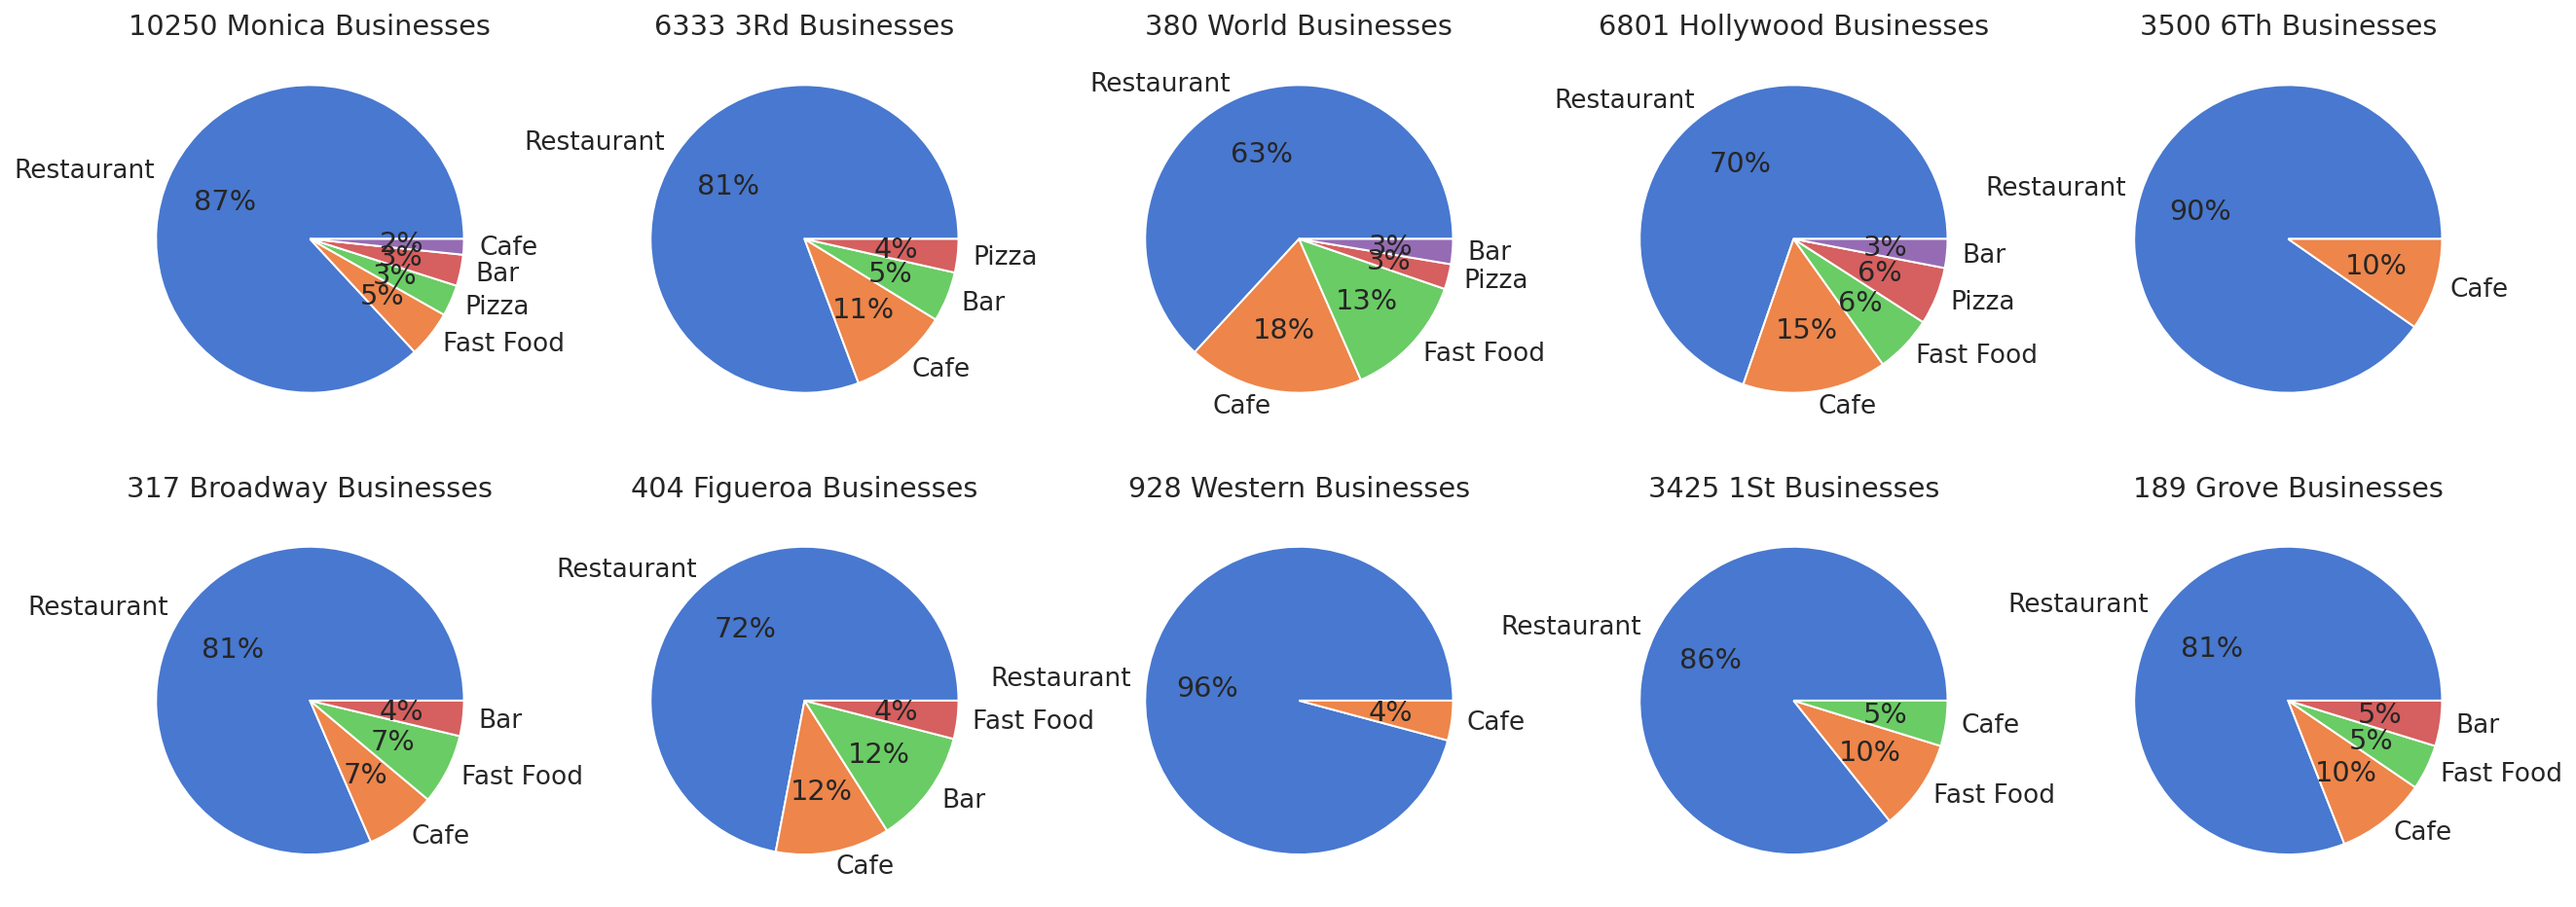

In [ ]:
fig = plt.figure(figsize=(22,8)) #,dpi=1600)

def pieplots(n1, n2, n3, n4, values, idx):
    ax1 = plt.subplot2grid((n1, n2),(n3, n4))
    plt.pie(values[idx],  labels=values[idx].keys(), autopct='%.0f%%')
    plt.title(top10.index[idx]+" Businesses")
    plt.savefig('multipie.png')

pieplots(2, 5, 0, 0, values, 0)
pieplots(2, 5, 0, 1, values, 1)
pieplots(2, 5, 0, 2, values, 2)
pieplots(2, 5, 0, 3, values, 3)
pieplots(2, 5, 0, 4, values, 4)

pieplots(2, 5, 1, 0, values, 5)
pieplots(2, 5, 1, 1, values, 6)
pieplots(2, 5, 1, 2, values, 7)
pieplots(2, 5, 1, 3, values, 8)
pieplots(2, 5, 1, 4, values, 9)

- Restaurants dominate with Fast Food and Cafe’s jockeying for second place from street to street.
- 317 S Broadway, Los Angeles or 928 Western have some potential, residential, limited competition, still being centrally located, close to well known landmarks and LA’s financial distriict

In [ ]:
top10SeatCountFilter = []

for street in top10.index:
  streetSeatCounts = df[df['cleanAddress'].str.contains(street)][['businessName', 'businessType', 'seatCount', 'cleanAddress', 'isChain']]
  top10SeatCountFilter.append(streetSeatCounts)

In [ ]:
top10SeatCounts = pd.concat(top10SeatCountFilter)
top10SeatCounts['cleanStreet'] = [x.split(",")[0] for x in top10SeatCounts['cleanAddress']]
top10SeatCounts.head()

,businessName,businessType,seatCount,cleanAddress,isChain,cleanStreet
407,Smitten Ice Cream,Restaurant,8,"10250 Monica, Los Angeles, USA",False,10250 Monica
422,Smitten Ice Cream Prep Kitchen,Restaurant,20,"10250 Monica, Los Angeles, USA",True,10250 Monica
433,Meizhou Dongpo,Restaurant,86,"10250 Monica, Los Angeles, USA",False,10250 Monica
435,Panini Kabob Grill,Restaurant,69,"10250 Monica, Los Angeles, USA",False,10250 Monica
970,Eataly,Restaurant,40,"10250 Monica, Los Angeles, USA",False,10250 Monica


In [ ]:
top10SeatCounts.groupby('isChain')['cleanStreet'].value_counts()

isChain  cleanStreet   
False    6333 3Rd          39
         10250 Monica      35
         380 World         23
         6801 Hollywood    22
         3500 6Th          18
         404 Figueroa      17
         928 Western       16
         3425 1St          15
         189 Grove         14
         317 Broadway      14
True     10250 Monica      26
         6333 3Rd          18
         380 World         15
         317 Broadway      13
         3500 6Th          13
         6801 Hollywood    11
         404 Figueroa       8
         928 Western        8
         189 Grove          7
         3425 1St           6
Name: cleanStreet, dtype: int64

In [ ]:
fig = px.box(top10SeatCounts, x='cleanStreet', y="seatCount", color='isChain', title='Busy Street Seat Count Per Street')
fig.show()

- Seat distribution varies across streets and chain vs independent businesses
- Some distributions have to few (less than 50 businesses) to visualize a proper distribution however 
- We can still see that there are fewer businesses with high seat counts and outliers than with the unfiltered dataset



In [ ]:
# plt.figure(figsize=(22,6))
# sns.boxplot(data=top10SeatCounts, x='cleanStreet', y='seatCount', hue='isChain')
# plt.savefig('top10Streets.png')
# plt.show()

In [ ]:
fig = px.box(top10SeatCounts, x='businessType', y="seatCount", color='isChain', title='Busy Street Seat Counts Per Business Type')
fig.show()

- Top 10 street seating pattern by business similar to unfiltered dataset.  

- Cafes tend to have 20-40 seats depending on weather its a chain or independent stores 


In [ ]:
top10SeatCounts[top10SeatCounts['businessType'] == 'Pizza']

,businessName,businessType,seatCount,cleanAddress,isChain,cleanStreet
1560,California Pizza Kitchen,Pizza,63,"10250 Monica, Los Angeles, USA",True,10250 Monica
8262,Joe'S Pizza,Pizza,44,"10250 Monica, Los Angeles, USA",True,10250 Monica
2622,Blaze Pizza Prep Kitchen,Pizza,5,"6333 3Rd, Los Angeles, USA",True,6333 3Rd
3385,Deano'S Gourment Pizza,Pizza,3,"6333 3Rd, Los Angeles, USA",False,6333 3Rd
2524,W Pizza,Pizza,105,"380 World, Los Angeles, USA",False,380 World
4536,California Pizza Kitchen #,Pizza,154,"6801 Hollywood, Los Angeles, USA",True,6801 Hollywood
7616,Calif Pizza Kitchen #,Pizza,192,"6801 Hollywood, Los Angeles, USA",True,6801 Hollywood


- Pizza Parlour seating is much high especially among chains with a number of “California Pizza Kitchen” stores located among these street

In [ ]:
# plt.figure(figsize=(22,6))
# sns.boxplot(data=top10SeatCounts, x='businessType', y='seatCount', hue='isChain')
# plt.savefig('top10StreetsSeats.png')
# plt.show()

# Find the number of streets that only have one restaurant

In [ ]:
quietStreets = establishmentCount[establishmentCount['totalEst'] == 1]

print("Number of Streets With One Establishment:", len(quietStreets))

Number of Streets With One Establishment: 4879


In [ ]:
quietStreetsEstTypeProportion = quietStreets.iloc[:, :-1].sum(axis=0)

fig = px.pie(quietStreetsEstTypeProportion, 
             values=quietStreetsEstTypeProportion.values, 
             names=quietStreetsEstTypeProportion.keys(), 
             title='Proportion of Establishment Type On Quiet Streets'
             )
fig.add_annotation(x=-0.09, y=1.05,
            text="Total Establishments: {}".format(len(quietStreets)),
            showarrow=False,
            yshift=10)


fig.show()

- Over 4800 streets have just one business - However should bring our cafe to a busier more trafficked location


In [ ]:
quietStreetSeatCountFilter = []

for street in quietStreets.index:
  streetSeatCounts = df[df['cleanAddress'].str.contains(street)][['businessType', 'seatCount', 'cleanAddress', 'isChain']]
  quietStreetSeatCountFilter.append(streetSeatCounts)

In [ ]:
quietSeatCounts = pd.concat(quietStreetSeatCountFilter)
quietSeatCounts['cleanStreet'] = [x.split(",")[0] for x in quietSeatCounts['cleanAddress']]
quietSeatCounts.head()

,businessType,seatCount,cleanAddress,isChain,cleanStreet
3146,Restaurant,40,"4803 Rock, Los Angeles, USA",False,4803 Rock
236,Restaurant,123,"8731 Lincoln, Los Angeles, USA",False,8731 Lincoln
8209,Restaurant,34,"4869 Monica, Los Angeles, USA",True,4869 Monica
2083,Restaurant,4,"4714 Main, Los Angeles, USA",False,4714 Main
927,Restaurant,3,"8809 Pico, Los Angeles, USA",True,8809 Pico


In [ ]:
quietSeatCounts['cleanAddress'].nunique()

4905

In [ ]:
quietSeatCounts.groupby('isChain')['businessType'].value_counts()

isChain  businessType
False    Restaurant      2454
         Cafe             342
         Fast Food        282
         Bar              104
         Pizza             90
True     Restaurant      1106
         Fast Food        349
         Cafe             168
         Pizza             76
         Bar               27
Name: businessType, dtype: int64

In [ ]:
quietSeatCounts.groupby('isChain')['businessType'].value_counts(normalize=True).round(2)

isChain  businessType
False    Restaurant      0.75
         Cafe            0.10
         Fast Food       0.09
         Bar             0.03
         Pizza           0.03
True     Restaurant      0.64
         Fast Food       0.20
         Cafe            0.10
         Pizza           0.04
         Bar             0.02
Name: businessType, dtype: float64

In [ ]:
fig = px.box(quietSeatCounts, x='businessType', y="seatCount", color='businessType', title='Queit Street Seat Counts Per Business Type')
fig.show()

In [ ]:
# plt.figure(figsize=(22,6))
# sns.boxplot(data=quietSeatCounts, x='businessType', y="seatCount", hue='isChain')
# plt.savefig('qquietStreets.png')
# plt.show()

In [ ]:
fig = px.box(quietSeatCounts, x='businessType', y="seatCount", color='isChain', title='Queit Street Seat Counts Per Business Type')
fig.show()

- Businesses can afford more seats on quiet streets

- Interestingly we dont see chain vs ibndependant having much effect on seating distribution between busy and quiet streets
- Pizza Parlours have lower seats on average on quiet streets, however there are greater numbers of Pizza Parlours bringing the distribution closer to a realistic population distribution


# Overall Conclusion
- The overall report and conclusions can be found here

- Presentation: [link](https://drive.google.com/drive/folders/1b-2wce1MdWN_eaJAugVAbIO2I08EyrCb)